In [ ]:
!git clone https://github.com/chronobreak42/Certificates.git

Cloning into 'Certificates'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 71 (delta 27), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (71/71), 15.00 MiB | 4.08 MiB/s, done.
Resolving deltas: 100% (27/27), done.


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
%cd Certificates

/content/Certificates


In [ ]:

!pip install torchtyping==0.1.5 # This version likely works better
!pip install typeguard==2.13.3 # This version is compatible with the recommended version of torchtyping.

!pip install --upgrade ogb

#!pip install torch==1.13.0 torchvision==0.15.2+rocm5.3 torchaudio==0.13.0+rocm5.2 -f https://download.pytorch.org/whl/torch_stable.html
!pip install torch torchvision torchaudio -f https://download.pytorch.org/whl/torch_stable.html
!pip install torch_geometric

# Installiert
!pip install tinydb
!pip install tinydb_serialization
!pip install seml==0.4.2



  Using cached torchtyping-0.1.5-py3-none-any.whl.metadata (9.5 kB)
  Using cached typeguard-2.13.3-py3-none-any.whl.metadata (3.6 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata

In [1]:
#5.0 (vor #5) run
from google.colab import drive #run
#drive.mount('/content/drive') #run
#!mkdir -p /content/drive/MyDrive/Colab\ Libraries/torch_geometric #create new directory


In [ ]:
#5
# Installiert, a) hat lange Installationszeit
# Alternative: b) Installation wird in Drive gespeichert und muss bei neuen Sitzungen nicht mehr ausgeführt werden
import os
import torch
import numpy
import collections.abc
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# a) Install directly
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# b) Install on mounted drive (faster alternative, you only need to run these once)
#!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html --target=/content/drive/MyDrive/Colab\ Libraries/torch_geometric
#!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html --target=/content/drive/MyDrive/Colab\ Libraries/torch_geometric
#!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git --target=/content/drive/MyDrive/Colab\ Libraries/torch_geometric


2.5.1+cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 59.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 46.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
#5.1 (nach #5) run
import sys
sys.path.append('/content/drive/MyDrive/Colab Libraries/torch_geometric')

In [ ]:
!pip install gmpy2 # Install the missing gmpy2 module.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 44.1 MB/s eta 0:00:00


In [ ]:
import torch
import numpy as np
from sparse_smoothing.models import GCN
from sparse_smoothing.utils import load_and_standardize
from sparse_smoothing.cert import p_lower_from_votes, binary_certificate_grid
from sparse_smoothing.cert import regions_discrete, compute_rho_for_many
from sparse_smoothing.prediction import predict_smooth_gnn

import seaborn as sns
import matplotlib.pyplot as plt

## Example certificate for binary data

#### Load pre-trained GCN model and load dataset

In [ ]:
graph = load_and_standardize('data/cora_ml.npz')
n, d = graph.attr_matrix.shape
nc = graph.labels.max() + 1

In [ ]:
import copy
pf_plus_att = 0.01
pf_minus_att = 0.6
#loaded = torch.load(f'data/gcn_pretrained_{pf_minus_att}_{pf_plus_att}')
loaded = torch.load(f'data/gcn_pretrained_{pf_minus_att}_{pf_plus_att}', map_location='cpu')

model = GCN(n_features=d, n_classes=nc, n_hidden=64)#.cuda()

# 2nd attempt
# Make a deep copy of the loaded state dictionary
new_state_dict = copy.deepcopy(loaded['state_dict'])

# Replace the keys, ensuring all weight keys are addressed
# Original keys might be 'conv1.weight', 'conv2.weight', 'lin.weight' etc.
# New keys likely to be 'conv1.lin.weight', 'conv2.lin.weight' etc.
for key in list(new_state_dict.keys()):
    if '.weight' in key and '.lin.weight' not in key:
        new_key = key.replace('.weight', '.lin.weight')
        new_state_dict[new_key] = new_state_dict.pop(key).T  # Transpose if necessary

# Load the modified state dictionary
model.load_state_dict(new_state_dict)

#model.load_state_dict(loaded['state_dict']) original line

edge_idx = torch.LongTensor(np.stack(graph.adj_matrix.nonzero()))#.cuda()
attr_idx = torch.LongTensor(np.stack(graph.attr_matrix.nonzero()))#.cuda()

<ipython-input-7-72870717185d>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded = torch.load(f'data/gcn_pretrained_{pf_minus_att}_{pf_plus_att}', map_location='cpu')


In [ ]:
n_samples_eval = 100_000

sample_config = {
    'n_samples': n_samples_eval,
    'pf_plus_adj': 0,
    'pf_minus_adj': 0,
    'pf_plus_att': 0.01,
    'pf_minus_att': 0.6,
}
batch_size = 50

sample_config_pre_eval = sample_config.copy()
sample_config_pre_eval['n_samples'] = 1_000


import torch


# we a small number of samples to estimate the majority class
pre_votes = predict_smooth_gnn(attr_idx=attr_idx, edge_idx=edge_idx,
                               sample_config=sample_config_pre_eval,
                               model=model, n=n, d=d, nc=nc,
                               batch_size=batch_size)

# we use a larger number of samples to estimate a lower bound
# on the probability of observing the majority class
votes = predict_smooth_gnn(attr_idx=attr_idx, edge_idx=edge_idx,
                           sample_config=sample_config,
                           model=model, n=n, d=d, nc=nc,
                           batch_size=batch_size)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [12]:
from torch_sparse import spmm
from torch_geometric.nn.conv.gcn_conv import gcn_norm
y = spmm(attr_idx, torch.ones_like(attr_idx[0]), n, d, model.conv1.lin.weight.T)

edge_idx, norm = gcn_norm(edge_idx, None, y.size(0), model.conv1.improved, model.conv1.add_self_loops)

In [13]:
gcn_norm?

In [14]:
model.conv1.lin.weight.shape,n,d


(torch.Size([64, 2879]), 2810, 2879)

In [15]:
model.conv1.lin.weight.size(-2)

64

In [16]:
conf_alpha = 0.01

# compute the lower bound on the probability of the majority class
p_lower = p_lower_from_votes(votes=votes, pre_votes=pre_votes, alpha=conf_alpha, n_samples=n_samples_eval)

# compute the binary-class certificate 2D grid (for all pairs of ra and rd radii)
# where grid_binary_class > 0.5 means the instance is robust
grid_binary_class, *_ = binary_certificate_grid(pf_plus=pf_plus_att, pf_minus=pf_minus_att,
                                            p_emps=p_lower, reverse=False, progress_bar=True)

max_ra=3, max_rd=10, min_p_emp=0.6970


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

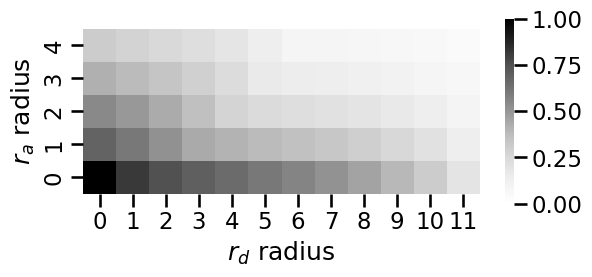

In [55]:
heatmap = grid_binary_class.mean(0)
sns.set_context('talk')
sns.heatmap(heatmap,
            cmap='Greys',
            vmin=0, vmax=1, square=True, cbar_kws={"shrink": .5})
plt.xlim(0, heatmap.shape[1])
plt.ylim(0, heatmap.shape[0])
plt.xlabel('$r_d$ radius')
plt.ylabel('$r_a$ radius')
plt.show()

# Example certificate for discrete data

In [18]:
# generate toy data, replace this with actual samples from your model
np.random.seed(0)
n_instances = 1000
pre_votes = np.random.multinomial(n=n_samples_eval, pvals=[0.001, 0.001, 0.998], size=n_instances)
votes = np.random.multinomial(n=n_samples_eval, pvals=[0.001, 0.001, 0.998], size=n_instances)

In [19]:
# compute the lower bound on the probability of the majority class
p_lower = p_lower_from_votes(votes=votes, pre_votes=pre_votes, alpha=conf_alpha, n_samples=n_samples_eval)

In [37]:
# if pf_plus = pf_minus any combination of ra+rd+rc=r gives the same result.
pf_plus = 0.99
pf_minus = 0.99
ra = 1
rd = 100
rc = 0

n_discrete_categories = 256

regions = regions_discrete(ra=ra, rd=rd, rc=rc, k=n_discrete_categories, pf_plus=pf_plus, pf_minus=pf_minus)

percent_robust = (compute_rho_for_many(regions=regions, p_emps=p_lower)>0.5).mean() * 100

print(f'At radius r={ra+rd+rc}, {percent_robust} percent of nodes are certifiably robust')

At radius r=101, 100.0 percent of nodes are certifiably robust


# **Gemini explaination for regions_discrete:**

**Purpose:**

This function constructs regions of constant probability under both the original data distribution (px) and a perturbed data distribution (px_tilde). These regions are crucial for calculating certified radii in the context of robustness verification for discrete data.

**Steps and Reasoning:**

**Precision Setup:**

It initializes gmpy2 for high-precision floating-point calculations, ensuring accuracy in the probability calculations.
**Distribution Definitions:**

dist_0 and dist_1 represent the probabilities of different types of flips (zero to non-zero, non-zero to zero, etc.) under the original and perturbed distributions, respectively. They are calculated based on the given flip probabilities (pf_plus, pf_minus) and the number of discrete categories (k).
**Iterating Through Regions:**

It iterates through all possible combinations of flips (triplet) using the product and triplets functions. Each triplet represents a specific region.
**Calculating Ratio and Probabilities:**

For each region, it calculates the ratio (ratio) between the probabilities of the original and perturbed distributions (px/px_tilde).
It then calculates the probability of the original distribution (px) for that region using a multinomial distribution formula.
**Storing Regions:**

Finally, it stores the calculated px, px_tilde (derived from px and ratio), and ratio for each region in the regions dictionary.
**In Summary:**

This function generates a set of regions with their corresponding probabilities under both the original and perturbed data distributions. These regions are then used by other functions to determine the certified radius, which is a measure of how much the input data can be perturbed before the model's prediction changes.